<a href="https://colab.research.google.com/github/santolina/Convolutional-Neural-Networks-in-TensorFlow/blob/master/Course_4_S%2BP_Week_2_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install tf-nightly-2.0-preview
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 41kB/s 
     |████████████████████████████████| 3.8MB 54.0MB/s 
     |████████████████████████████████| 450kB 40.9MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=2)

print("Layer weights {}".format(l0.get_weights()))



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 - 0s - loss: 1759.8733
Epoch 2/100
31/31 - 0s - loss: 173.8581
Epoch 3/100
31/31 - 0s - loss: 101.9986
Epoch 4/100
31/31 - 0s - loss: 94.4581
Epoch 5/100
31/31 - 0s - loss: 90.0010
Epoch 6/100
31/31 - 0s - loss: 88.9907
Epoch 7/100
31/31 - 0s - loss: 86.2171
Epoch 8/100
31/31 - 0s - loss: 83.7350
Epoch 9/100
31/31 - 0s - loss: 81.7916
Epoch 10/100
31/31 - 0s - loss: 77.9570
Epoch 11/100
31/31 - 0s - loss: 76.4217
Epoch 12/100
31/31 - 0s - loss: 75.5342
Epoch 13/100
31/31 - 0s - loss: 73.8489
Epoch 14/100
31/31 - 0s - loss: 71.9931
Epoch 15/100
31/31 - 0s - loss: 69.6705
Epoch 16/100
31/31 - 0s - loss: 69.8996
Epoch 17/100
31/31 - 0s - loss: 68.2986
Epoch 18/100
31/31 - 0s - loss: 67.5377
Epoch 19/100
31/31 - 0s - loss: 67.0960
Epoch 20/100
31/31 - 0s - loss: 65.4755
Epoch 21/100
31/31 - 0s - loss: 65.6765
Epoch 22/100
31/31 - 0s - loss: 64.8709
Epoch 23/100
31/31 - 0s - loss: 63.4301
Ep

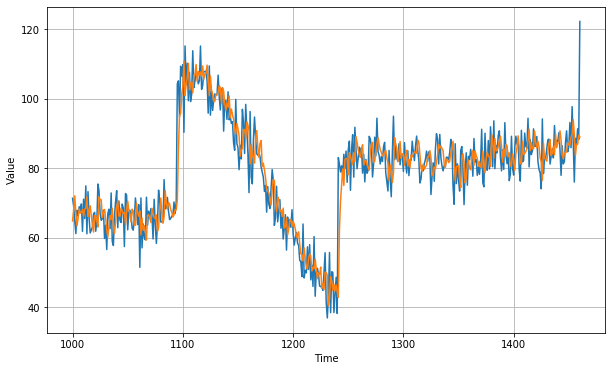

In [6]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.998534